# Prepare Google Colab Environment

In [1]:
!git clone https://github.com/JoepMulder/STEGO.git

Cloning into 'STEGO'...
remote: Enumerating objects: 402, done.
remote: Counting objects: 100% (290/290), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 402 (delta 202), reused 212 (delta 150), pack-reused 112
Receiving objects: 100% (402/402), 9.41 MiB | 30.10 MiB/s, done.
Resolving deltas: 100% (236/236), done.


In [2]:
!pip install tensorflow[and-cuda]
!pip install wget
!pip install torchmetrics
!pip install hydra-core
!pip install git+https://github.com/lucasb-eyer/pydensecrf.git
!pip install omegaconf
!pip install pytorch-lightning
!pip install torch

  Preparing metadata (setup.py) ... done
INFO: pip is looking at multiple versions of tensorflow[and-cuda] to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 412.6/412.6 MB 1.4 MB/s eta 0:00:0000:0100:04m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 2.0 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 3.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.9/24.9 MB 4.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 867.7/867.7 kB 4.2 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 704.7/704.7 MB 1.7 MB/s eta 0:00:0000:0100:04
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 MB 4.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 3.6 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.2/125.2 MB 2.2 MB/s eta 0:00:0000:0100:02
  

# Download Pretrained Model



In [3]:
import os
from os.path import join
os.chdir("STEGO/src")
saved_models_dir = join("..", "saved_models")
os.makedirs(saved_models_dir, exist_ok=True)


../saved_models


In [4]:
import wget
saved_model_url_root = "https://marhamilresearch4.blob.core.windows.net/stego-public/saved_models/"
saved_model_name = "cocostuff27_vit_base_5.ckpt"
if not os.path.exists(join(saved_models_dir, saved_model_name)):
    wget.download(saved_model_url_root + saved_model_name, join(saved_models_dir, saved_model_name))

../saved_models
../saved_models/cocostuff27_vit_base_5.ckpt
aa


# Load pretrained STEGO

In [5]:
from train_segmentation import LitUnsupervisedSegmenter

model = LitUnsupervisedSegmenter.load_from_checkpoint(join(saved_models_dir, saved_model_name)).cuda()

/kaggle/working/STEGO/src/train_segmentation.py:397: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="configs", config_name="train_config.yml")
/opt/conda/lib/python3.10/site-packages/pytorch_lightning/utilities/migration/migration.py:207: You have multiple `ModelCheckpoint` callback states in this checkpoint, but we found state keys that would end up colliding with each other after an upgrade, which means we can't differentiate which of your checkpoint callbacks needs which states. At least one of your `ModelCheckpoint` callbacks will not be able to reload the state.
Downloading: "https://dl.fbaipublicfiles.com/dino/dino_vitbase8_pretrain/dino_vitbase8_pretrain.pth" to /root/.cache/torch/hub/checkpoints/dino_vitbase8_pretrain.pth


Since no pretrained weights have been provided, we load the reference pretrained DINO weights.


100%|██████████| 327M/327M [00:01<00:00, 204MB/s]  


test/cluster/
{'test/cluster/mIoU': nan, 'test/cluster/Accuracy': nan}
test/linear/
{'test/linear/mIoU': nan, 'test/linear/Accuracy': nan}
final/cluster/
{'final/cluster/mIoU': nan, 'final/cluster/Accuracy': nan}
final/linear/
{'final/linear/mIoU': nan, 'final/linear/Accuracy': nan}


/opt/conda/lib/python3.10/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric UnsupervisedMetrics was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)  # noqa: B028


# Load Image

In [6]:
from PIL import Image
import requests
from io import BytesIO
from torchvision.transforms.functional import to_tensor
from utils import get_transform

img_url ="https://marhamilresearch4.blob.core.windows.net/stego-public/sample_images/moto1.jpg"
response = requests.get(img_url)
img = Image.open(BytesIO(response.content))
transform = get_transform(448, False, "center")
img = transform(img).unsqueeze(0).cuda()

# Query model and pass result through CRF

In [7]:
import torch.nn.functional as F
from crf import dense_crf
import torch

with torch.no_grad():
  code1 = model(img)
  code2 = model(img.flip(dims=[3]))
  code  = (code1 + code2.flip(dims=[3])) / 2
  code = F.interpolate(code, img.shape[-2:], mode='bilinear', align_corners=False)
  linear_probs = torch.log_softmax(model.linear_probe(code), dim=1).cpu()
  cluster_probs = model.cluster_probe(code, 2, log_probs=True).cpu()

  single_img = img[0].cpu()
  linear_pred = dense_crf(single_img, linear_probs[0]).argmax(0)
  cluster_pred = dense_crf(single_img, cluster_probs[0]).argmax(0)


# Visualize Result

Note that cluster predictions will not be matched with ground truth classes in this example. For hungarian matching please use: `eval_segmentation.py`

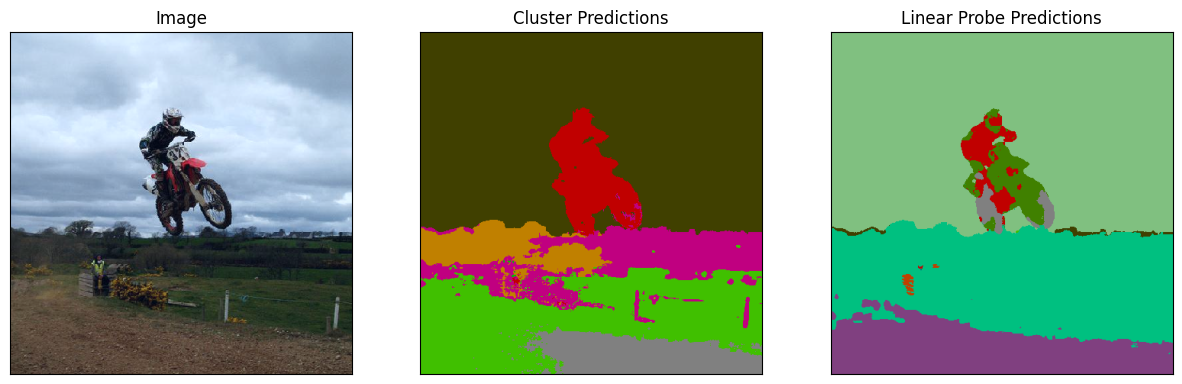

In [8]:
import os
import matplotlib.pyplot as plt
from utils import unnorm, remove_axes

dire = join("..", "STEGO/results/reproduce")
os.makedirs(dire, exist_ok=True)

fig, ax = plt.subplots(1,3, figsize=(5*3,5))
ax[0].imshow(unnorm(img)[0].permute(1,2,0).cpu())
ax[0].set_title("Image")
ax[1].imshow(model.label_cmap[cluster_pred])
ax[1].set_title("Cluster Predictions")
ax[2].imshow(model.label_cmap[linear_pred])
ax[2].set_title("Linear Probe Predictions")
remove_axes(ax)
plt.savefig(f"../STEGO/results/reproduce/test.png")

# Download models




In [12]:
!python download_models.py


Found ../models/moco_v2_800ep_pretrain.pth.tar, skipping download

Found ../models/model_epoch_0720_iter_085000.pth, skipping download

Found ../models/picie.pkl, skipping download

Found ../saved_models/cityscapes_vit_base_1.ckpt, skipping download

Found ../saved_models/cocostuff27_vit_base_5.ckpt, skipping download

Found ../saved_models/picie_and_probes.pth, skipping download

Found ../saved_models/potsdam_test.ckpt, skipping download


# Evaluate dataset
Change the dataset url to the dataset you wish to evaluate and update the eval_config accordingly

In [13]:
!python eval_segmentation.py

/kaggle/working/STEGO/src/train_segmentation.py:397: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="configs", config_name="train_config.yml")
/kaggle/working/STEGO/src/eval_segmentation.py:57: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  @hydra.main(config_path="configs", config_name="eval_config.yml")
start prep_args
finished prep_args
start my_app
/opt/conda/lib/python3.10/site-packages/hydra/plugins/config_source.py:125: UserWarning: Support for .yml files is deprecated. Use .yaml extension for Hydra config files
  deprecation_warning(
/opt/conda/lib/python3.10/site-packages/hydra/_internal/hydra.py:119: UserWarning: Future Hydra versions will no longer change working directory at job runtime by default.
See https://hydra.cc/docs/1.2/upgrades/1.1_t